In [1]:
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Normalize the data

First I defined a function to normalize the data in a range between $[-1, 1]$. Then using the parameter of the normalization (maximun and minimum) I create a function that denormalize the data.

In [2]:
min_vector = []
max_vector = []
median_vector = []
def normalize(dataset):
    for i in range(dataset.shape[0]):
        for k in range(dataset.shape[1]):

            max_ = np.max(dataset[i,k,:])
            max_vector.append(max_)
          
            min_ = np.min(dataset[i,k,:])
            min_vector.append(min_)
          
            median = np.median(dataset[i,k,:])
            median_vector.append(median)
            dataset[i,k,:] = 2*((dataset[i,k,:] - min_)/(max_-min_))-1

def denormalize(M_vec, m_vec, dataset):
  M = sum(M_vec)/len(M_vec)
  m = sum(m_vec)/len(m_vec)
  
  for i in range(dataset.shape[0]):
    for k in range(dataset.shape[1]):
      dataset[i,k,:] = m + (M-m)*(dataset[i,k,:]+1)/2

## Data loading

In [36]:
#Preparing the data (loading and normalization)
data = np.load('data/TOD.npy')
test = np.load('data/TOD_test.npy')

#Remove the time axis that is irrelenvant in the training
dataset = data[:,1,:,:].copy()
test = test[:,1,:,:]

normalize(dataset)
print("The train dataset shape is: " + str(dataset.shape))
print("The test dataset shape is: " + str(test.shape))

The train dataset shape is: (896, 12, 3126)
The test dataset shape is: (104, 12, 3126)


## Hyperparameters

In [4]:
data_shape = dataset.shape[1:]
noise_dim = 500
epochs = 100
BATCH_SIZE = 64

# GAN architecture

### Discriminator

In [5]:
def get_discriminator_model():
    
    model = Sequential()

    model.add(layers.Input(shape = data_shape))
    
    model.add(layers.Conv1D(16, 12, strides = 1, data_format='channels_first',activation = 'swish'))
    model.add(layers.LayerNormalization())

    model.add(layers.Conv1D(32, 12, strides = 2, data_format='channels_first',activation = 'swish'))
    model.add(layers.LayerNormalization())

    model.add(layers.Conv1D(64, 12, strides = 3, data_format='channels_first',activation = 'swish'))
    model.add(layers.LayerNormalization())

    model.add(layers.Flatten())  
    model.add(layers.Dropout(0.5))  
    model.add(layers.Dense(1))

    return model

d_model = get_discriminator_model()
d_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 3115)          2320      
_________________________________________________________________
layer_normalization (LayerNo (None, 16, 3115)          6230      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 1552)          6176      
_________________________________________________________________
layer_normalization_1 (Layer (None, 32, 1552)          3104      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 514)           24640     
_________________________________________________________________
layer_normalization_2 (Layer (None, 64, 514)           1028      
_________________________________________________________________
flatten (Flatten)            (None, 32896)             0

### Generator

In [6]:
def get_generator_model():
    
    model = Sequential()
    
    model.add(layers.Input(shape = noise_dim))
    model.add(layers.Reshape((1, noise_dim)))
    
    model.add(layers.Conv1DTranspose(4 , 12, strides = 1, padding = 'same', data_format='channels_first', activation = 'swish'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv1DTranspose(8 , 12, strides = 2, padding = 'same', data_format='channels_first', activation = 'swish'))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv1DTranspose(12, 12, strides = 2, padding = 'same', data_format='channels_first', activation = 'swish'))
  
    model.add(layers.Dense(data_shape[1], activation='tanh'))

    return model

g_model = get_generator_model()
g_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 500)            0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 4, 500)            52        
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 500)            2000      
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 8, 1000)           392       
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 1000)           4000      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 12, 2000)          1164      
_________________________________________________________________
dense_1 (Dense)              (None, 12, 3126)         

## Wasserstein GAN with gradient penalty

In [7]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn


    def gradient_penalty(self, batch_size, real_data, fake_data):
        # get the interplated data
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_data - real_data
        interpolated = real_data + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated sample
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated sample
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        # Get the batch size
        batch_size = tf.shape(real_data)[0]

        #-------------------------#
        # Train the DISCRIMINATOR #
        #-------------------------#
        
        for i in range(self.d_steps):
            
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                
                # Generate fake sample from the latent vector
                fake_data = self.generator(random_latent_vectors, training=True)
                
                fake_logits = self.discriminator(fake_data, training=True)
                real_logits = self.discriminator(real_data, training=True)

                # Calculate discriminator loss
                d_cost = self.d_loss_fn(real_=real_logits, fake_=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_data, fake_data)
                
                # Add the gradient penalty to the discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        #---------------------#
        # Train the GENERATOR #
        #---------------------#
        
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        with tf.GradientTape() as tape:
            # Generate fake sample using the generator
            generated_data = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake samples
            gen_img_logits = self.discriminator(generated_data, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

In [8]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)

def discriminator_loss(real_, fake_):
    real_loss = tf.reduce_mean(real_)
    fake_loss = tf.reduce_mean(fake_)
    return fake_loss - real_loss

def generator_loss(fake_):
    return -tf.reduce_mean(fake_)


# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=4,
    gp_weight = 10.0
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

### Start the training

In [9]:
history = wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs)

Epoch 1/100
14/14 [==============================] - 2s 168ms/step - d_loss: 46.0618 - g_loss: 4.5053
Epoch 2/100
14/14 [==============================] - 2s 174ms/step - d_loss: -3.0882 - g_loss: 6.5088
Epoch 3/100
14/14 [==============================] - 2s 175ms/step - d_loss: -0.9589 - g_loss: 2.2587
Epoch 4/100
14/14 [==============================] - 2s 177ms/step - d_loss: -0.2077 - g_loss: 0.4443
Epoch 5/100
14/14 [==============================] - 3s 180ms/step - d_loss: -0.1364 - g_loss: 0.2197
Epoch 6/100
14/14 [==============================] - 3s 180ms/step - d_loss: -0.2775 - g_loss: 0.1092
Epoch 7/100
14/14 [==============================] - 2s 177ms/step - d_loss: -0.3462 - g_loss: 0.0762
Epoch 8/100
14/14 [==============================] - 3s 188ms/step - d_loss: -0.4440 - g_loss: 0.0404
Epoch 9/100
14/14 [==============================] - 3s 184ms/step - d_loss: -0.4915 - g_loss: -0.0265
Epoch 10/100
14/14 [==============================] - 3s 185ms/step - d_loss: -0.

### Visualize the generator and the discriminator loss function

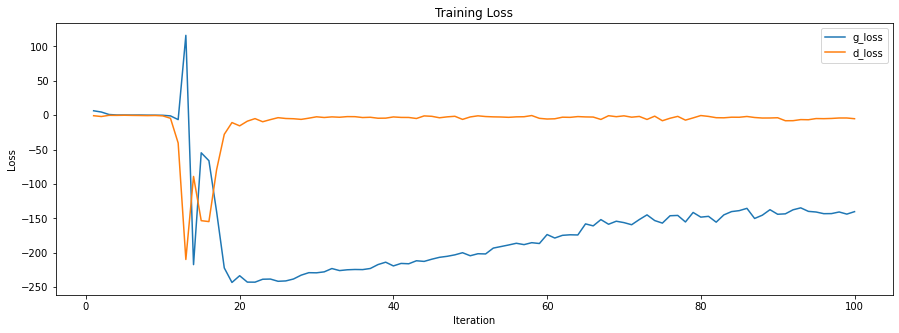

In [10]:
g_loss = history.history['g_loss']
d_loss = history.history['d_loss']
steps = range(1,len(g_loss)+1)

plt.figure(figsize=(15,5))
plt.plot(steps, g_loss, label = 'g_loss')
plt.plot(steps, d_loss, label = 'd_loss')

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

In [24]:
import seaborn as sns

z = np.random.normal(0.0, 1.0, (100, 500))
new = g_model.predict(z)
denormalize(max_vector, min_vector, new)

<AxesSubplot:title={'center':'GAN'}>

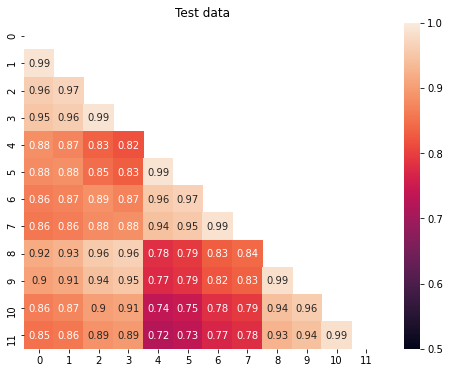

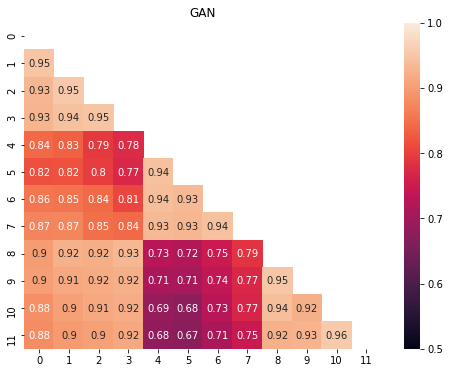

In [25]:
matrix_true = np.corrcoef(test[0])
for i in range(1,test.shape[0]):
  matrix_true += np.corrcoef(test[i])
matrix_true = matrix_true/test.shape[0]

matrix = np.corrcoef(new[0])
for i in range(1,new.shape[0]):
  matrix += np.corrcoef(new[i])
matrix = matrix/new.shape[0]

mask = np.triu(np.ones_like(matrix, dtype=bool))

plt.figure(figsize = (8,6))
plt.title('Test data')
sns.heatmap(matrix_true, mask = mask, annot = True, vmin = 0.5, vmax = 1)

plt.figure(figsize = (8,6))
plt.title('GAN')
sns.heatmap(matrix, mask = mask, annot = True, vmin = 0.5, vmax = 1)

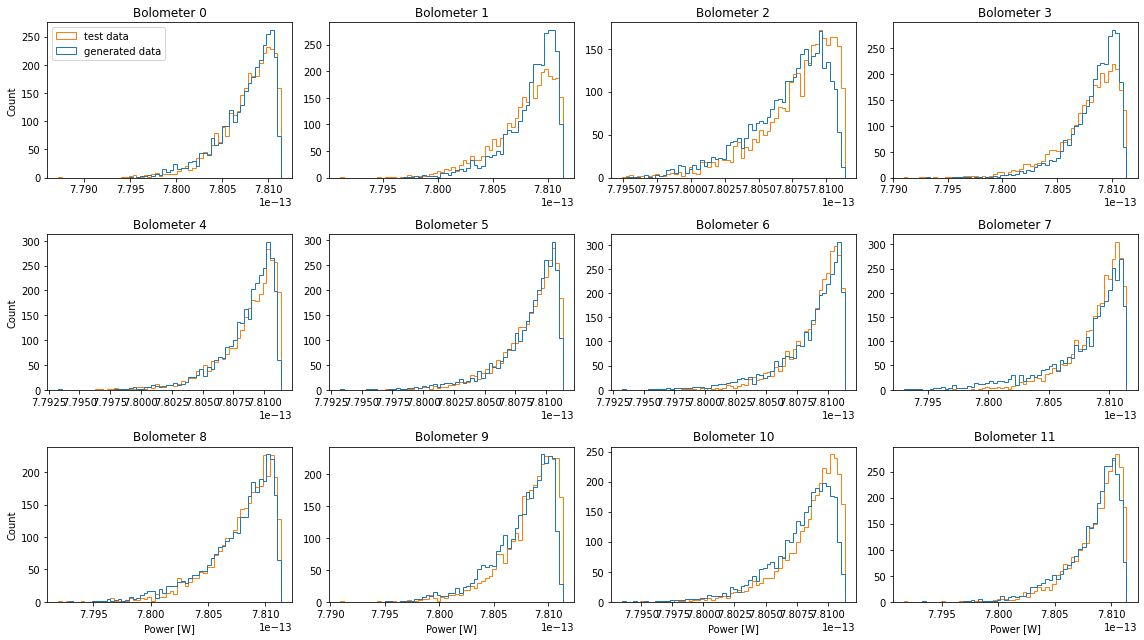

In [32]:
z = np.random.normal(0,1, (test.shape[0], 500))
g_data = g_model.predict(z)
denormalize(max_vector, min_vector, g_data)

fig, ax = plt.subplots(3,4,figsize = (16,9))

plt.setp(ax[-1, :], xlabel='Power [W]')
plt.setp(ax[:, 0], ylabel='Count')

for i in range(3):
  for k in range(4):
    ax[i,k].set_title('Bolometer ' + str(k + i*4))
    ax[i,k].hist([g_data[np.random.randint(0, g_data.shape[0]-1),k+i*4],test[np.random.randint(0,test.shape[0]-1),k+i*4]], 60,histtype = 'step', 
                 label=['generated data', 'test data'])
ax[0,0].legend(loc='upper left')
plt.tight_layout()